In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
#from datetime import datetime

In [ ]:
#Read the csv file
df = pd.read_csv('/content/GoogleRevenue.csv')
print(df.head())

         Date  Revenue (in millions of $)
0   3/30/2008                        5186
1   6/30/2008                        5637
2   9/30/2008                        5541
3  12/30/2008                        5701
4   3/30/2009                        5509


In [ ]:
#Separate dates for future plotting
train_dates = pd.to_datetime(df['Date'])
print(train_dates.tail(15)) #Check last few dates. 

43   2018-12-30
44   2019-03-30
45   2019-06-30
46   2019-09-30
47   2019-12-30
48   2020-03-30
49   2020-06-30
50   2020-09-30
51   2020-12-30
52   2021-03-30
53   2021-06-30
54   2021-09-30
55   2021-12-30
56   2022-03-30
57   2022-06-30
Name: Date, dtype: datetime64[ns]


In [ ]:
#Variable for training
col = list(df)[1]
#Date and volume columns are not used in training. 
print(col) 

Revenue (in millions of $)


In [ ]:
#New dataframe with only training data - 1 column
df_for_training = df[col].astype(float)
df_for_training

df_for_training.shape

(58,)

In [ ]:
#Feature Scaling or Standardization: It is a step of Data Pre Processing that is applied to independent variables or features of data. It basically helps to normalize the data within a particular range
#StandardScaler is useful for the features that follow a Normal distribution.MinMaxScaler may be used when the upper and lower boundaries are well known from domain knowledge. StandardSCalar changes the shape of data while keeping data into range of 0 and 1. It can eliminate the outliers(which sometimes provides some useful info). NOTE: Do not remove all outliers until you do not have domain knowledge sbout them.If you know you have a fixed min and max in your dataset (e.g. images), you can use min-max scaling to fix your input and/or output data to be between 0 and 1. MinMaxScalar() do not changes the shape of data, while it also keeps the data into range of 0 and 1. It will do it for minimum number of features required.For other applications where you do not have fixed bounds, standard scaling is useful. This gives all of your features zero-mean and unit variance.

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df_for_training_scaled=scaler.fit_transform(np.array(df_for_training).reshape(-1,1))
print(df_for_training_scaled) # we can see that now the closing prices are from 0 to 1.

[[0.        ]
 [0.00646549]
 [0.00508924]
 [0.00738298]
 [0.00463049]
 [0.00483119]
 [0.01088094]
 [0.0213318 ]
 [0.02277973]
 [0.02342484]
 [0.03010537]
 [0.04664899]
 [0.04858433]
 [0.05504982]
 [0.06499892]
 [0.07738513]
 [0.07825962]
 [0.08283277]
 [0.09088954]
 [0.11065873]
 [0.11131819]
 [0.11355458]
 [0.1228299 ]
 [0.1508279 ]
 [0.1467135 ]
 [0.1543832 ]
 [0.16252598]
 [0.18365709]
 [0.17191599]
 [0.17872554]
 [0.19135546]
 [0.22927389]
 [0.21369077]
 [0.23108021]
 [0.24468497]
 [0.29554871]
 [0.27857501]
 [0.29713999]
 [0.31946097]
 [0.38715504]
 [0.37000932]
 [0.39174253]
 [0.40725396]
 [0.48472511]
 [0.44220486]
 [0.48008028]
 [0.50231525]
 [0.58240986]
 [0.51306716]
 [0.47038922]
 [0.58534872]
 [0.73855638]
 [0.71735359]
 [0.8101068 ]
 [0.8556806 ]
 [1.        ]
 [0.89035911]
 [0.91650778]]


In [ ]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 5. We will make timesteps = 365 (past days data used for training). 

#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of quarters we want to look into the future based on the past quarters.
n_past = 20  # Number of past quarters we want to use to predict the future.

In [ ]:
#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 1)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[0]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape)) 

#In trainX: 3823 refers to the number of data points [total data points aka 4553 - n_future & n_past] and 5 refers to the columns (multi-variables).

trainX shape == (38, 20, 1).
trainY shape == (38, 1).


In [ ]:
# define the Autoencoder model

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
3/3 [==============================] - 6s 411ms/step - loss: 0.1586 - val_loss: 0.8106
Epoch 2/10
3/3 [==============================] - 0s 58ms/step - loss: 0.1407 - val_loss: 0.7222
Epoch 3/10
3/3 [==============================] - 0s 70ms/step - loss: 0.1228 - val_loss: 0.6589
Epoch 4/10
3/3 [==============================] - 0s 58ms/step - loss: 0.1072 - val_loss: 0.6026
Epoch 5/10
3/3 [==============================] - 0s 69ms/step - loss: 0.1046 - val_loss: 0.5424
Epoch 6/10
3/3 [==============================] - 0s 37ms/step - loss: 0.0791 - val_loss: 0.4582
Epoch 7/10
3/3 [==============================] - 0s 76ms/step - loss: 0.0706 - val_loss: 0.3449
Epoch 8/10
3/3 [==============================] - 0s 52ms/step - loss: 0.0359 - val_loss: 0.1999
Epoch 9/10
3/3 [==============================] - 0s 47ms/step - loss: 0.0206 - val_loss: 0.0416
Epoch 10/10
3/3 [==============================] - 0s 39ms/step - loss: 0.0199 - val_loss: 0.0102


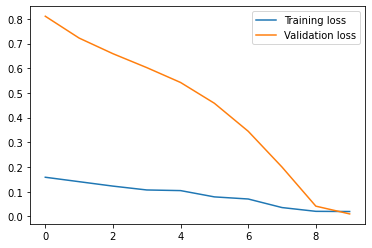

In [ ]:
# fit the model
history = model.fit(trainX, trainY, epochs=10, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()


In [ ]:
#Forecasting:

n_future=9 # as we have quaterly data. 1 year has 4 quaters. 8 data points= 2 years but value 0 will be our existing data so i put 9
forecast_period_dates= pd.date_range(list(train_dates)[-1],periods=n_future,freq='90d').tolist() #freq= 3 months x 30 days = 90

forecast=model.predict(trainX[-n_future:])

1/1 [==============================] - 1s 1s/step


In [ ]:
forecast_copies= np.repeat(forecast,df_for_training.shape[0],axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]

In [ ]:
forecast_dates= []
for time_i in forecast_period_dates:
  forecast_dates.append(time_i.date())

df_forecast = pd.DataFrame({'Date' :np.array(forecast_dates), 'Revenue':y_pred_future})
df_forecast['Date']= pd.to_datetime(df_forecast['Date'])


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


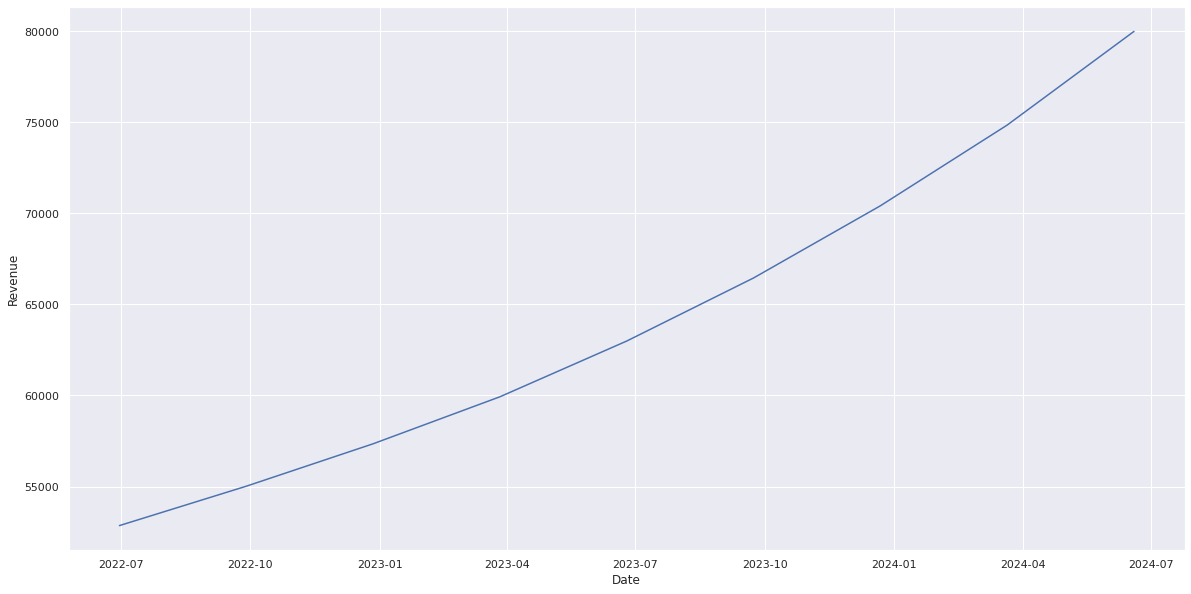

In [ ]:
original = df[['Date','Revenue (in millions of $)']]
original['Date']= pd.to_datetime(original['Date'])
original = original.loc [original['Date']>= '2022-9-30']

sns.lineplot(original['Date'], original['Revenue (in millions of $)'])
sns.lineplot(df_forecast['Date'], df_forecast['Revenue'])

sns.set(rc={'figure.figsize':(10,10)})

In [ ]:
df_forecast #this shows the forecasted stock prices for the next year

,Date,Revenue
0,2022-06-30,52858.113281
1,2022-09-28,55019.210938
2,2022-12-27,57347.437500
3,2023-03-27,59927.683594
4,2023-06-25,62987.878906
5,2023-09-23,66449.179688
6,2023-12-22,70411.179688
7,2024-03-21,74842.710938
8,2024-06-19,79984.578125


# **As per my forecast, in 2 years Google's revenue will be $79,984 million.**